# Setting

If you want to create an environment, run the following commands step by step.

- Create a conda environment
    - conda create -n hyundai python=3.9
    - conda activate hyundai


- Install packages
    - pip install gymnasium matplotlib "gymnasium[toy-text]"

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
print("numpy version", np.__version__)
print("gymnasium (gym) version", gym.__version__)
print("matplotlib version", matplotlib.__version__)

numpy version 2.0.2
gymnasium (gym) version 1.1.1
matplotlib version 3.9.4


# Environment

*OpenAI gym FrozenLake environment*

Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located

    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.

In [2]:
env = gym.make("FrozenLake-v1", render_mode="rgb_array").unwrapped

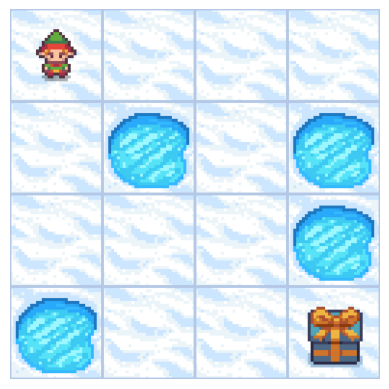

In [3]:
obs, info = env.reset(seed=1)

# Get Image
img = env.render()   # numpy array (H, W, 3)

plt.imshow(img)
plt.axis("off")
plt.show()

In [4]:
env.P[6][0]

[(0.3333333333333333, 2, 0.0, False),
 (0.3333333333333333, 5, 0.0, True),
 (0.3333333333333333, 10, 0.0, False)]

- from state 6 and taking action 0, there is 0.33 probability transitioning to state 2, with reward 0.0, transition is non-terminal
- from state 6 and taking action 0, there is 0.33 probability transitioning to state 5, with reward 0.0, transition is terminal, MDP ends
- from state 6 and taking action 0, there is 0.33 probability transitioning to state 10, with reward 0.0, transition is non-terminal

# Problem 1 (Policy iteration)

In [5]:
def policy_evaluation(env, pi, V, gamma, theta):
    """
    Policy Evaluation: iterative policy evaluation until convergence
    """
    while True:
        delta = 0
        for s in range(env.observation_space.n):
            v = V[s]
            val = 0
            for a, action_prob in enumerate(pi[s]):
                for prob, next_state, reward, done in env.P[s][a]:
                    val += action_prob * prob * (reward + gamma * V[next_state])
            V[s] = val
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V

In [6]:
def policy_improvement(env, V, pi, gamma):
    """
    Policy Improvement: update pi greedily wrt V
    """
    policy_stable = True
    action = np.zeros(env.observation_space.n, dtype=int)

    for s in range(env.observation_space.n):
        old_action = np.argmax(pi[s])  # best action under old policy

        # compute q(s,a) for each action
        q_vals = np.zeros(env.action_space.n)
        for a in range(env.action_space.n):
            for prob, next_state, reward, done in env.P[s][a]:
                q_vals[a] += prob * (reward + gamma * V[next_state])

        best_action = np.argmax(q_vals)

        # update policy to greedy
        pi[s] = np.eye(env.action_space.n)[best_action]
        action[s] = best_action

        if best_action != old_action:
            policy_stable = False

    return pi, action, policy_stable

In [7]:
def policy_iteration(env, gamma=0.95, theta=1e-6):
    """
    Policy Iteration algorithm
    """
    # initialize V(s) and pi(a|s)
    V = np.zeros(env.observation_space.n)
    pi = np.ones((env.observation_space.n, env.action_space.n)) / env.action_space.n  # uniform random policy

    while True:
        # Policy Evaluation
        V = policy_evaluation(env, pi, V, gamma, theta)

        # Policy Improvement
        pi, action, stable = policy_improvement(env, V, pi, gamma)

        if stable:
            break  # policy converged

    return V, pi, action

In [8]:
## DO NOT CHANGE THIS CELL

gamma = 0.99
theta = 0.000001

# 학습 (Policy Iteration)
env.reset(seed=1)
V, pi, action = policy_iteration(env, gamma, theta)  # note "action" is optimal policy with discrete action number

# 평가
num_episodes = 1000
episode_max_length = 10000

successes = 0
for i_episode in range(num_episodes):
    s, _ = env.reset()
    for t in range(episode_max_length):
        s, reward, terminated, truncated, _ = env.step(action[s])
        done = terminated or truncated
        if done:
            if reward == 1:
                successes += 1
            break

print("Agent succeeded to reach goal {} out of {} Episodes using this policy".format(successes, num_episodes))
print("Success rate:", successes / num_episodes)

env.close()

Agent succeeded to reach goal 824 out of 1000 Episodes using this policy
Success rate: 0.824


In [9]:
V.reshape(4, -1)

array([[0.54201384, 0.49878716, 0.47067695, 0.45683159],
       [0.55844022, 0.        , 0.35833998, 0.        ],
       [0.59178999, 0.64307352, 0.61520205, 0.        ],
       [0.        , 0.7417161 , 0.86283524, 0.        ]])

In [10]:
a2w = {0:'<', 1:'v', 2:'>', 3:'^'}
policy_arrows = np.array([a2w[np.argmax(x)] for x in pi])
print(policy_arrows.reshape(4, -1))

[['<' '^' '^' '^']
 ['<' '<' '<' '<']
 ['^' 'v' '<' '<']
 ['<' '>' 'v' '<']]


# Problem 2 (Value iteration)

In [11]:
def argmax(env, V, pi, action, s, gamma):
    e = np.zeros(env.action_space.n)
    for a in range(env.action_space.n): # iterate for every action possible
        q = 0
        P = env.P[s][a]
        for prob, next_state, reward, done in P:    # iterate for every possible states
            q += prob * (reward + gamma * V[next_state])    # calculate action_ value q(s|a)
        e[a] = q

    m = np.argmax(e)
    action[s] = m   # Take index which has maximum value 
    pi[s][m] = 1    # update pi(a|s) 

    return pi

In [12]:
def bellman_opt_update(env, V, s, gamma): # update the state_value V[s]
    e = np.zeros(env.action_space.n)
    for a in range(env.action_space.n):
        val = 0
        P = env.P[s][a]
        for prob, next_state, reward, done in P:
            val += prob * (reward + gamma * V[next_state])
        e[a] = val

    V[s] = np.max(e)

In [13]:
def value_iteration(env, gamma, theta):
    V = np.zeros(env.observation_space.n)   # initialize v(0) to arbitory value, my case "zeros"
    while True:
        delta = 0
        for s in range(env.observation_space.n):    # iterate for all states
            v = V[s]
            bellman_opt_update(env, V, s, gamma)    # update state_value with bellman optimality update
            delta = max(delta, abs(v - V[s]))   # assign the change in value per iteration to delta  
        if delta < theta:
            break   # if change gets to negligible --> converged to optimal value

    pi = np.zeros((env.observation_space.n, env.action_space.n))
    action = np.zeros((env.observation_space.n))
    for s in range(env.observation_space.n):
        pi = argmax(env, V, pi, action, s, gamma)   # extract optimal policy using action value 

    return V, pi, action     # optimal value funtion, optimal policy with one-hot encoding (pi), optimal policy with discrete number (action)

In [14]:
## DO NOT CHANGE THIS CELL

gamma = 0.99
theta = 0.000001

env.reset(seed=1)
V, pi, action = value_iteration(env, gamma, theta) # note "action" is optimal policy with discrete action number

#initialize episodic structure
num_episodes=1000
episode_max_length=10000

e=0
for i_episode in range(num_episodes):
    s, _ = env.reset()
    for t in range(episode_max_length):
        s, reward, done, truncate, _ = env.step(action[s])
        if done:
            if reward == 1:
                e +=1
            break
print(" agent succeeded to reach goal {} out of {} Episodes using this policy ".format(e+1, num_episodes))
print(" success rate:", (e+1)/num_episodes)
env.close()

 agent succeeded to reach goal 825 out of 1000 Episodes using this policy 
 success rate: 0.825


In [15]:
V.reshape(4, -1)

array([[0.54201404, 0.49878743, 0.47067727, 0.45683193],
       [0.5584404 , 0.        , 0.35834012, 0.        ],
       [0.59179013, 0.64307363, 0.61520214, 0.        ],
       [0.        , 0.74171617, 0.86283528, 0.        ]])

In [16]:
a2w = {0:'<', 1:'v', 2:'>', 3:'^'}
policy_arrows = np.array([a2w[np.argmax(x)] for x in pi])
print(policy_arrows.reshape(4, -1))

[['<' '^' '^' '^']
 ['<' '<' '<' '<']
 ['^' 'v' '<' '<']
 ['<' '>' 'v' '<']]


# Problem 2 (Q-learning)

For proper accounting rewards while you learn, we build a wrapper around env.step() and env.reset(). In an episode, every time you take an action the reward will be appended to the reward of the episode, and when ever the environment is reset (at the end of an epsiode), the episode reward is reset to 0. 

In [78]:
# reward tracking
rEpisode = 0
rList = []

# reset wrapper
def reset_decorate(func):
    def func_wrapper(*args, **kwargs):
        global rList, rEpisode
        rList.append(rEpisode)
        rEpisode = 0
        return func(*args, **kwargs)  # Gymnasium: (obs, info)
    return func_wrapper

env.reset = reset_decorate(env.reset)

# step wrapper (Gymnasium: 5개 리턴)
def step_decorate(func):
    def func_wrapper(action):
        global rEpisode
        obs, reward, terminated, truncated, info = func(action)
        rEpisode += reward
        done = terminated or truncated
        # Gymnasium 그대로 반환
        return obs, reward, terminated, truncated, info
    return func_wrapper

env.step = step_decorate(env.step)

def init():
    global rEpisode, rList
    rEpisode = 0
    rList = []
    return

In [79]:
## DO NOT CHANGE THIS CELL
# PLOTTING functions
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'valid')
import matplotlib.pyplot as plt

Below we illustrate the execution of the Open AI gym enviornment using the policy of chosing random action in every state. Every time an action is taken the enviorment returns a tuple containing next state, reward, and the status (whether terminal state is reached or not). 

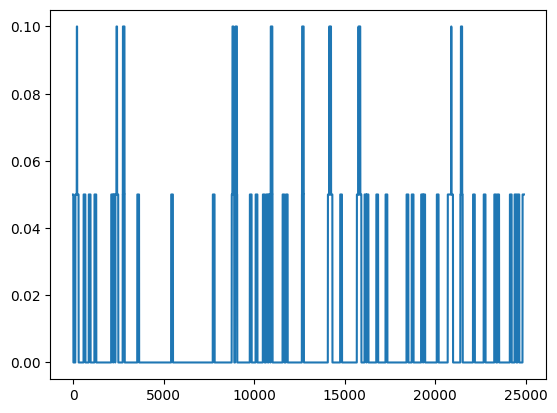

In [80]:
## DO NOT CHANGE THIS CELL
### RANDOM SAMPLING EXAMPLE
num_episodes = 5000   # number of episodes
episode_max_length = 100   # max steps per episode

for i in range(num_episodes):
    # reset environment
    s, info = env.reset()
    
    for t in range(episode_max_length):
        ################ Random action policy ###########################
        a = env.action_space.sample()
        
        # step (Gymnasium: 5개 리턴)
        s, r, terminated, truncated, info = env.step(a)
        done = terminated or truncated
        #################################################################
        
        if done:
            break

# moving average of episode rewards
rm = movingaverage(rList, 100)
plt.plot(rm)
rEpisode = 0
rList = []

Implement tabular Q-learning (*YOU SHOULD ONLY CHANGE THE CELL BELOW*)

In [81]:
## CHANGE THIS CELL BY YOURSELF
### ALWAYS DO RUN ALL CELLS, otherwise some structures may not get initialized properly
rEpisode = 0
rList = []

# initialize episodic structure
num_episodes = 5000
episode_max_length = 100

# initialize discount factor, learning rate
gamma = 0.95
learnRate = 0.8

## Epsilon greedy
eps = 0.9
eps_decay = 0.99
##

# Gymnasium에서 seed는 이렇게 설정
env.reset(seed=111)

# create Q table
Q = np.zeros([env.observation_space.n, env.action_space.n])  # matrix Q[s,a]

# execute in episodes
for i in range(num_episodes):
    
    # reset the environment at the beginning of an episode
    s, info = env.reset()
    s = int(s)   # Discrete state → int 변환
    d = False    # not done
    
    for t in range(episode_max_length):
        
        ########### SELECT ACTION a for state s using Q-values ##################
        # e-greedy action
        if np.random.rand() < eps:
            a = env.action_space.sample()
        else:
            a = np.argmax(Q[s, :]) 

        # get new state, reward, done
        s1, r, terminated, truncated, info = env.step(a)
        d = terminated or truncated
        s1 = int(s1)  # Discrete state → int 변환
        
        ##### update Q(s,a) ############
        ## Q-learning update: Bellman Optimal Equation update
        Q[s][a] = Q[s][a] + learnRate * (r + gamma * np.max(Q[s1, :]) - Q[s][a])
        
        # break if done, reached terminal state 
        if d:
            break
        s = s1
    
    eps = eps * eps_decay

plot moving average over 100 episodes

Solved after 2251 episodes.


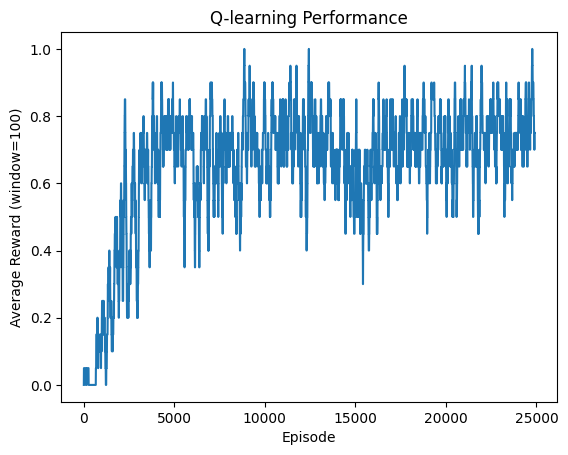

In [82]:
## DO NOT CHANGE THIS CELL
rm = movingaverage(rList, 100)

import matplotlib.pyplot as plt
plt.plot(rm)
plt.xlabel("Episode")
plt.ylabel("Average Reward (window=100)")
plt.title("Q-learning Performance")

criterion = len(np.where(rm >= 0.78)[0]) > 0
if criterion:
    print("Solved after %d episodes." % np.where(rm >= 0.78)[0][0])
else:
    print("Unsolved Yet!")

# Problem 3 (SARSA)
Implement tabular SARSA (*YOU SHOULD ONLY CHANGE THE CELL BELOW*)

In [83]:
num_episodes = 5000
episode_max_length = 100
gamma = 0.95
learn_rate = 0.8
eps = 0.9
eps_decay = 0.99


env.reset(seed=10)
# Q-table 초기화
Q = np.zeros([env.observation_space.n, env.action_space.n])

# 실행
for i in range(num_episodes):
    # Reset the environment at the beginning of an episode
    s, info = env.reset()
    s = int(s)
    done = False  

    # 초기 행동 선택 (e-greedy)
    if np.random.rand() < eps:
        a = env.action_space.sample()
    else:
        a = np.argmax(Q[s, :])
        
    for t in range(episode_max_length):

        # Step
        s1, r, terminated, truncated, info = env.step(a)
        done = terminated or truncated
        s1 = int(s1)

        # 다음 행동 선택 (e-greedy)
        if np.random.rand() < eps:
            a1 = env.action_space.sample()
        else:
            a1 = np.argmax(Q[s1, :])

        # SARSA 업데이트
        Q[s][a] = Q[s][a] + learn_rate * (r + gamma * Q[s1][a1] - Q[s][a])

        # 종료
        if done:
            break

        # 상태, 행동 업데이트
        s, a = s1, a1

    # Epsilon decay
    eps = eps * eps_decay

    # Policy improvement
    pi = np.argmax(Q, axis=1)

Solved after 2251 episodes.


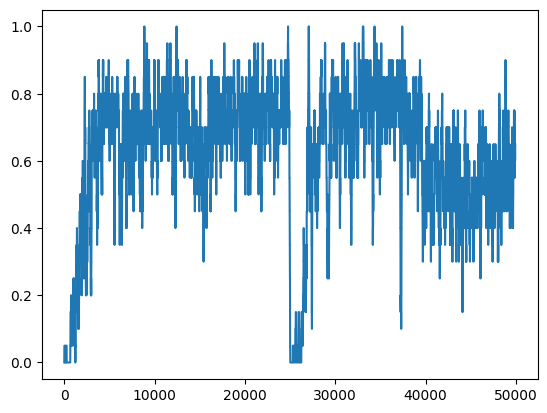

In [84]:
## DO NOT CHANGE THIS CELL
rm = movingaverage(rList, 100)
plt.plot(rm)
criterion = len(np.where(rm >= .78)[0]) > 0
if criterion:
    print("Solved after %d episodes." % np.where(rm >= .78)[0][0])
else:
    print("Unsolved Yet!")

# Problem 4 (Dyna-Q)

In [85]:
import time
from matplotlib import pyplot as plt

In [86]:
import numpy as np
import gymnasium as gym

class Agent():
    def __init__(self, env, total_episodes, step_limit, epsilon, epsilon_decay,
                 min_epsilon, gamma, alpha, alpha_decay, min_alpha):
        self.env = env
        self.action_space = env.action_space.n
        self.observation_space = env.observation_space.n
        self.qtable = np.zeros((self.observation_space, self.action_space))
        self.total_rewards = []
        self.total_steps = []
        self.total_episodes = total_episodes
        self.step_limit = step_limit
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.gamma = gamma
        self.alpha = alpha
        self.alpha_decay = alpha_decay
        self.min_alpha = min_alpha
    
    def alpha_schedule(self, episode):
        if (episode + 1) % 1000 == 0:
            self.alpha *= self.alpha_decay
            self.alpha = max(self.alpha, self.min_alpha)
    
    def epsilon_schedule(self, episode):
        if (episode + 1) % 1000 == 0:
            self.epsilon *= self.epsilon_decay
            self.epsilon = max(self.epsilon, self.min_epsilon)
    
    def learn(self, state_old, state_new, reward, action):
        prediction = self.qtable[state_old, action]
        target = reward + self.gamma * np.max(self.qtable[state_new, :])
        self.qtable[state_old, action] += self.alpha * (target - prediction)
    
    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.qtable[state, :])
    
    def train(self):
        episode_print_split = self.total_episodes // 5
        for episode in range(self.total_episodes):
            state, info = self.env.reset()
            state = int(state)
            self.alpha_schedule(episode)
            self.epsilon_schedule(episode)
            episode_reward = 0

            for t in range(self.step_limit):
                action = self.choose_action(state)
                state_new, reward, terminated, truncated, info = self.env.step(action)
                done = terminated or truncated
                state_new = int(state_new)

                # update Q-table
                self.learn(state, state_new, reward, action)

                state = state_new
                episode_reward += reward

                if done:
                    self.total_rewards.append(episode_reward)
                    self.total_steps.append(t+1)
                    if (episode + 1) % episode_print_split == 0:
                        outcome = 'win' if reward > 0.0 else 'lose'
                        print(f'Episode {episode+1} | {t+1} steps | {outcome}')
                    break

        print('')
        total_win_rate = sum(self.total_rewards) / self.total_episodes
        print(f'Total win rate {total_win_rate:.3f}')

    def moving_average(self, window):
        weights = np.repeat(1.0, window) / window
        return np.convolve(self.total_rewards, weights, 'valid')

In [87]:
total_episodes = 100000
step_limit = 100 # max steps per episode
epsilon = 1
epsilon_decay = 0.2
min_epsilon = 1e-4
gamma = 0.95
alpha = .8
alpha_decay = 0.3
min_alpha = 1e-4

# env = gym.make('FrozenLake-v1')
frozenlake = Agent(env, total_episodes, step_limit, epsilon, epsilon_decay,
                 min_epsilon, gamma, alpha, alpha_decay, min_alpha)
frozenlake.train()

Episode 20000 | 20 steps | win
Episode 40000 | 12 steps | win
Episode 60000 | 40 steps | lose
Episode 80000 | 37 steps | win
Episode 100000 | 33 steps | win

Total win rate 0.712


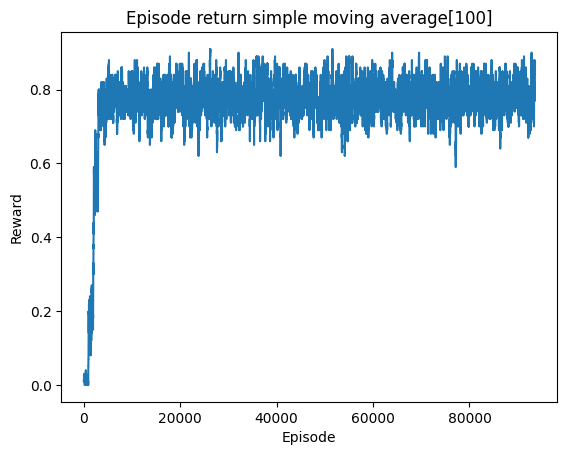

In [27]:
window = 100
average_reward = frozenlake.moving_average(window)

plt.figure(dpi = 100)
plt.title(f'Episode return simple moving average[{window}]')
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.plot(average_reward)